# Прогнозирование температуры при помощи RNN сети со слоями GRU и фильтром Хинтона (для регуляризации)

In [2]:
import os
print(os.getcwd())

fname = ('jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

C:\Users\rusmch\Desktop\File\ALL\Python_script
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Данные в массив Numpy

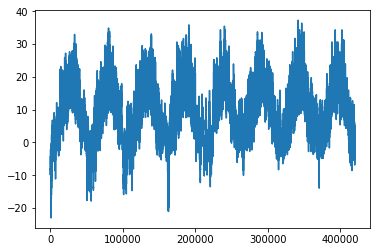

In [4]:
import numpy as np
from matplotlib import pyplot as plt

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp)
plt.show()

# Подготовка данных


Стандартизация

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Функция подготовки сэмплов для тестовой и обучающей выборки

In [6]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Формируем три выборки:тест,трейн и валидацию

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

# Два слоя GRU c проререживанием

In [36]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 346s - loss: 0.3341 - val_loss: 0.2780
Epoch 2/40
500/500 [==============================] - 344s - loss: 0.3125 - val_loss: 0.2754
Epoch 3/40
500/500 [==============================] - 344s - loss: 0.3045 - val_loss: 0.2696
Epoch 4/40
500/500 [==============================] - 344s - loss: 0.3018 - val_loss: 0.2747
Epoch 5/40
500/500 [==============================] - 344s - loss: 0.2957 - val_loss: 0.2690
Epoch 6/40
500/500 [==============================] - 344s - loss: 0.2923 - val_loss: 0.2692
Epoch 7/40
500/500 [==============================] - 344s - loss: 0.2907 - val_loss: 0.2673
Epoch 8/40
500/500 [==============================] - 343s - loss: 0.2879 - val_loss: 0.2690
Epoch 9/40
500/500 [==============================] - 343s - loss: 0.2866 - val_loss: 0.2743
Epoch 10/40
500/500 [==============================] - 344s - loss: 0.2833 - val_loss: 0.2669
Epoch 11/40
500/500 [==============================] - 344s - loss: 0

Проверим результаты на валидационной выборке

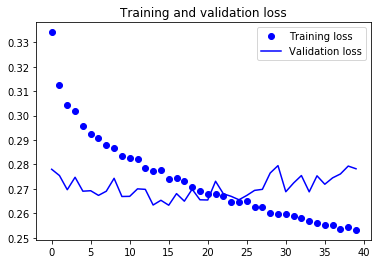

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()